In [ ]:
#The below shows that higher val acc is generally accomplished with smaller batch sizes since this has a regularizing effect on the model.
#Smaller batch sizes mean longer training epochs due a higher number of forward and back propagations during each epoch.
#The below data suggests that a batch size of 6 is reasonably good. Converting the main configuration to this value.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display
import numpy as np

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines()]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [53]:
df.batch_size = df.batch_size.astype('uint8')

In [55]:
#Shows the models that had a median validation accuracy greater that 65% over the last 4 epochs
val = df[df.epoch > 6].groupby(factors.columns[0]).describe()['Validation Accuracy']
val = val.sort_values('50%',ascending=False).iloc[0:6,:]

display(val)

#The smallest of the below models performed the best according to the median validation accuracy. Likely due to less overfitting
#Should conduct further analysis on these models to determine the next experiement.

val = val.reset_index().iloc[:,0:-8]
val['modelID'] = range(1,val.shape[0]+1)

top_perf = pd.merge(left=df, right = val.reset_index(), how= 'left').pipe(lambda df_: df_[df_['modelID'].notnull()])

train_acc = top_perf.groupby(['modelID', 'epoch']).describe().loc[:,'Train Accuracy'].reset_index()
val_acc = top_perf.groupby(['modelID', 'epoch']).describe().loc[:,'Validation Accuracy'].reset_index()

,count,mean,std,min,25%,50%,75%,max
batch_size,,,,,,,,
2,20.0,0.706060,0.047931,0.621201,0.675018,0.704595,0.741950,0.773517
37,20.0,0.669664,0.069129,0.557525,0.616407,0.696816,0.728111,0.748915
4,20.0,0.693651,0.024794,0.609986,0.691480,0.696274,0.711107,0.714182
6,20.0,0.696237,0.017469,0.671129,0.689942,0.691028,0.699530,0.727207
9,20.0,0.678491,0.042245,0.584298,0.643271,0.682344,0.717619,0.750362
34,20.0,0.654631,0.051805,0.568741,0.615412,0.677822,0.684244,0.722865


Text(0.5, 0.98, 'Median Model Accuracy of Top 6 Performing Models')

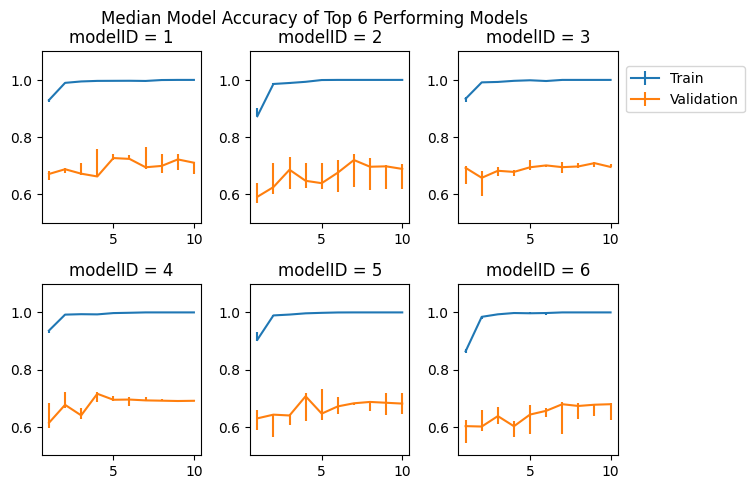

In [56]:
plt.figure()
for id in val_acc.modelID.unique():
    val_df = val_acc[val_acc.modelID == id]
    train_df = train_acc[train_acc.modelID == id]

    plt.subplot((230 + int(id)))

    plt.errorbar(x = train_df['epoch'],
                y = train_df['50%'],
                yerr = [(train_df['50%'] - train_df['25%']).to_numpy(), (train_df['75%'] - train_df['50%']).to_numpy()],
                label = 'Train')

    plt.errorbar(x = val_df['epoch'],
                y = val_df['50%'],
                yerr = [(val_df['50%'] - val_df['25%']).to_numpy(), (val_df['75%'] - val_df['50%']).to_numpy()],
                label = 'Validation')

    plt.title(f'modelID = {int(id)}')
    plt.ylim((0.5,1.1))

plt.tight_layout()
plt.legend(loc=(1.05,2))
plt.suptitle("Median Model Accuracy of Top 6 Performing Models", va = 'baseline')

Text(0, 0.5, 'Validation Accuracy')

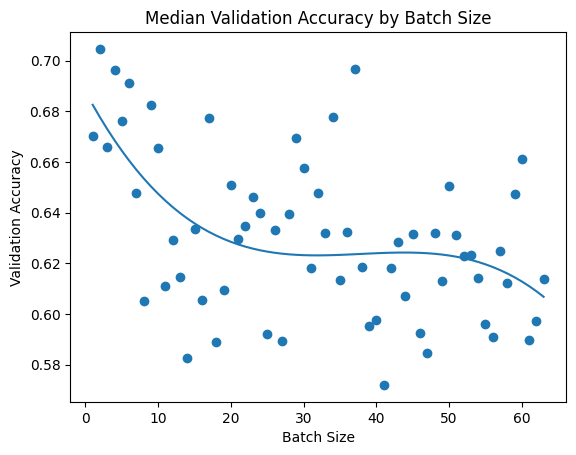

In [85]:
val = df[df.epoch > 6].groupby(factors.columns[0]).describe()['Validation Accuracy'].reset_index().sort_values('batch_size')

x= val['batch_size']
y = val['50%']

p = np.poly1d(np.polyfit(x, y, 3))

plt.scatter(x = val['batch_size'],
                y = val['50%'],
                label = 'Validation')

plt.plot(x, p(x))

plt.title("Median Validation Accuracy by Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
